1. 뉴스 데이터 : 매체, 제목, 날짜, 본문, 작성시간, url
2. 뉴스 별 댓글 데이터 :

# 1. 네이버뉴스 - 언론사 list 추출

In [1]:
#lib import
import requests
from bs4 import BeautifulSoup
import re
from datetime import date, timedelta
import json

## 1-1 언론사별 랭킹뉴스 > 댓글 많은 뉴스 URL에서 크롤링 시작

https://news.naver.com/main/ranking/popularMemo.naver?date=20220427

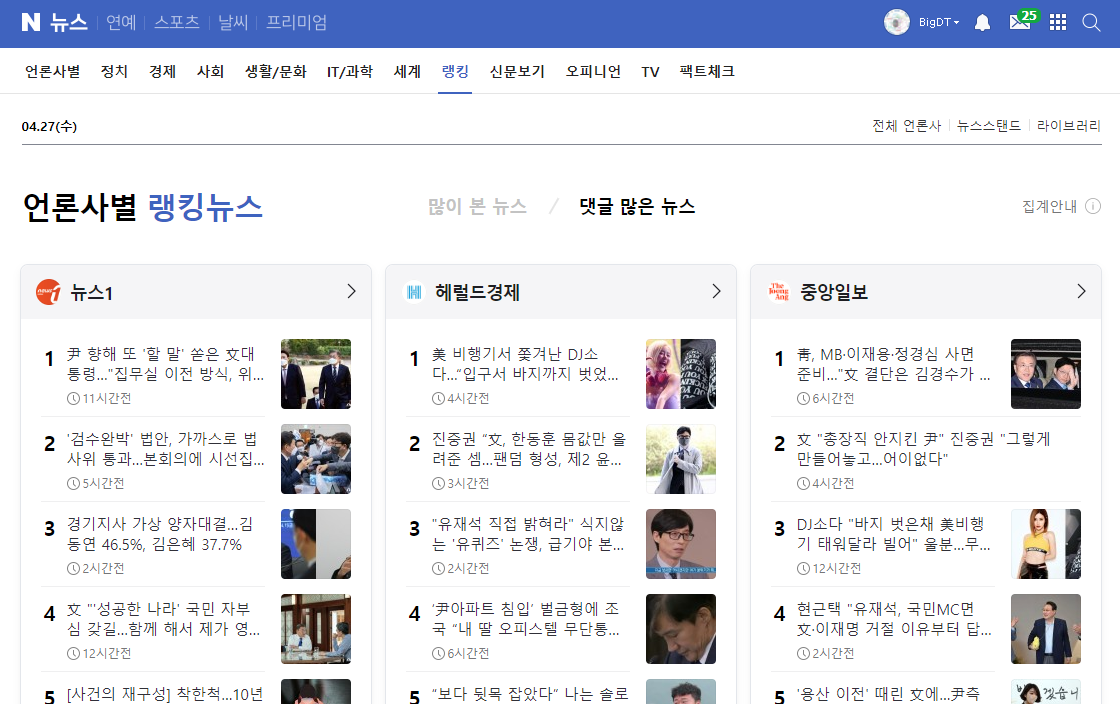

In [2]:
url = "https://news.naver.com/main/ranking/popularMemo.naver?date=20220427"

In [3]:
#URL headers 등록

#해당 site의 user-agent 확인.
#위치 : F12 -> Network -> Headers
headers = {
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36"
}
res = requests.get(url,headers = headers)

In [4]:
#상태값 확인 -> 200 : 성공 응답
res.status_code

200

In [5]:
#Beautifulsoup으로 URL 구성하고 있는 html 전체 긁어오기

soup = BeautifulSoup(res.text,'lxml') #lxml 파서 사용하는이유? 제일 빨라서
print(soup)
#참고: https://randomtip.tistory.com/26

<!DOCTYPE HTML>
<html lang="ko">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta contents="always" name="referrer"/>
<meta content="600" http-equiv="refresh"/>
<meta content="width=1106" name="viewport"/>
<meta content="telephone=no" name="format-detection"/>
<meta content="네이버 뉴스" property="og:title"/>
<meta content="website" property="og:type"/>
<meta content="https://news.naver.com/main/home.naver" property="og:url"/>
<meta content="https://ssl.pstatic.net/static.news/image/news/ogtag/navernews_200x200_20160804.png" property="og:image"/>
<meta content="정치, 경제, 사회, 생활/문화, 세계, IT/과학 등 언론사별, 분야별 뉴스 기사 제공" property="og:description"/>
<meta content="네이버" property="og:article:author"/>
<meta content="summary" name="twitter:card"/>
<meta content="네이버 뉴스" name="twitter:title"/>
<meta content="네이버 뉴스" name="twitter:site"/>
<meta content="네이버 뉴스" name="twitter:creator"/>
<meta content="https://ssl.pstatic.net/static.news/image/news/ogtag/navernews_2

##### 참고
부모 자식 관계는 space

직속 관계면 > 

select 하면 list형태로 나옴.

## 1-2 Card0에 해당하는 부분만 추출해보기(continue Card12,24,36....)

In [6]:
#officeCard0에 해당하는 언론사 list,url 추출
lis = soup.select("div._officeCard._officeCard0 > div")
for li in lis:
    url = li.select("a")[0]["href"]
    txt = li.select("a > strong.rankingnews_name")[0].text
    print(txt,url)

아시아경제 https://media.naver.com/press/277/ranking?type=comment
연합뉴스 https://media.naver.com/press/001/ranking?type=comment
파이낸셜뉴스 https://media.naver.com/press/014/ranking?type=comment
YTN https://media.naver.com/press/052/ranking?type=comment
JTBC https://media.naver.com/press/437/ranking?type=comment
매일경제 https://media.naver.com/press/009/ranking?type=comment
중앙일보 https://media.naver.com/press/025/ranking?type=comment
한국일보 https://media.naver.com/press/469/ranking?type=comment
KBS https://media.naver.com/press/056/ranking?type=comment
조선일보 https://media.naver.com/press/023/ranking?type=comment
헤럴드경제 https://media.naver.com/press/016/ranking?type=comment
한겨레 https://media.naver.com/press/028/ranking?type=comment


## 1-3 모든 언론사 list 추출
- Naver 뉴스에는 총 77개의 언론사가 있다.

In [7]:
#officeCard0~ 마지막까지 다 뽑아내야지
lis_num = 1 #언론사 count 변수
lis = soup.find_all("div",{"class":re.compile('^_officeCard _officeCard\d')})
for li in lis:  
    li_inner = li.select("div.rankingnews_box")
    print("###########################################################################")
    for at in li_inner:        
        txt = at.select("strong.rankingnews_name")[0].text
        url = at.select("a")[0]["href"]
        print(lis_num,txt,url)
        lis_num +=1
    

###########################################################################
1 아시아경제 https://media.naver.com/press/277/ranking?type=comment
2 연합뉴스 https://media.naver.com/press/001/ranking?type=comment
3 파이낸셜뉴스 https://media.naver.com/press/014/ranking?type=comment
4 YTN https://media.naver.com/press/052/ranking?type=comment
5 JTBC https://media.naver.com/press/437/ranking?type=comment
6 매일경제 https://media.naver.com/press/009/ranking?type=comment
7 중앙일보 https://media.naver.com/press/025/ranking?type=comment
8 한국일보 https://media.naver.com/press/469/ranking?type=comment
9 KBS https://media.naver.com/press/056/ranking?type=comment
10 조선일보 https://media.naver.com/press/023/ranking?type=comment
11 헤럴드경제 https://media.naver.com/press/016/ranking?type=comment
12 한겨레 https://media.naver.com/press/028/ranking?type=comment
###########################################################################
13 오마이뉴스 https://media.naver.com/press/047/ranking?type=comment
14 SBS https://media.naver.com/press

# 2. 언론사 별 뉴스 기사 가져오기(Rank 20까지)

## 2-1 언론사 1개의 뉴스 기사 가져와보기(Test)

-당일 기준이고  
네이버의 경우.. 동적 웹페이지인데(날자 바꿔도 url 바뀌지 않음)  
이 경우 동적 웹페이지 크롤링을 lib 써야함

-동적 웹페이지 크롤링(Selenium) 안써도 되는 방법 찾음!!! <br>
https://blog.naver.com/yundongcheol/220606742182  

예시 : https://media.naver.com/press/449/ranking?type=popular&date=20220420

In [8]:
#날짜 추출
from datetime import date, timedelta

today = date.today()
yesterday = date.today() - timedelta(1)
 
print(today.strftime('%Y%m%d')) #오늘
print(yesterday.strftime('%Y%m%d')) #어제

today = today.strftime('%Y%m%d')
yesterday = yesterday.strftime('%Y%m%d')

20220512
20220511


In [9]:
# 연합뉴스 랭킹 뉴스 기사 크롤링
#https://media.naver.com/press/055/ranking?type=comment

url2 = "https://media.naver.com/press/055/ranking?type=comment&date=" + str(yesterday) #headers 동일
res2 = requests.get(url2, headers=headers)
soup2 = BeautifulSoup(res2.text, 'lxml')
#soup2

#### HTML 구조파악
26일  
ct > div.press_ranking_home > div:nth-child(3) > ul > li:nth-child(1) > a > div.list_content > strong   
ct > div.press_ranking_home > div:nth-child(3) > ul > li:nth-child(2) > a > div.list_content > strong  
ct > div.press_ranking_home > div:nth-child(3) > ul > li:nth-child(6) > a > div.list_content > strong  
ct > div.press_ranking_home > div:nth-child(4) > ul > li:nth-child(1) > a > div.list_content > strong  
        
        
25일  
ct > div.press_ranking_home > div:nth-child(3) > ul > li:nth-child(1) > a > div.list_content > strong

In [10]:
#Test - 하나만 뽑아보기
newslist = soup2.select("div.press_ranking_home ul>li.as_thumb")
rn = newslist[0].select("em.list_ranking_num")[0].text
news_title = newslist[0].select("strong.list_title")[0].text
news_url= newslist[0].select("a")[0]["href"]
print(rn,news_title,news_url)

1 [Pick] "출소 후 변호사 되고 싶다"…'아동 성 착취' 최찬욱 감형 호소 https://n.news.naver.com/article/055/0000972554?ntype=RANKING


In [11]:
#(랭킹 20위) 뉴스 전체 다 뽑기(댓글 많은 순)
for li in newslist:
    rn = li.select("em.list_ranking_num")[0].text
    news_title = li.select("strong.list_title")[0].text
    news_url= li.select("a")[0]["href"]
    print(rn,news_title,news_url)

1 [Pick] "출소 후 변호사 되고 싶다"…'아동 성 착취' 최찬욱 감형 호소 https://n.news.naver.com/article/055/0000972554?ntype=RANKING
2 [영상] 오징어 맨발로 밟아대고 주물럭…1분 영상에 난리 났다 https://n.news.naver.com/article/055/0000972511?ntype=RANKING
3 고성 오간 한동훈 청문회…민주당 의원 '황당 질의' 실소 https://n.news.naver.com/article/055/0000972322?ntype=RANKING
4 [Pick] "중앙선 넘어 주차 후 짜장면 먹으러 간 일가족…과태료 참교육" https://n.news.naver.com/article/055/0000972471?ntype=RANKING
5 [비디오머그] 이게 '생일빵'이었다고? 제보자 분노하게 만든 집단폭행 중학생들 https://n.news.naver.com/article/055/0000972297?ntype=RANKING
6 송영길, 오세훈 'TV토론 거부'에 "뭐가 두려워서 피하나" https://n.news.naver.com/article/055/0000972564?ntype=RANKING
7 이재명, 방탄용 출마 지적에 "잘못한 게 없으면 걱정할 일도 없다" https://n.news.naver.com/article/055/0000972503?ntype=RANKING
8 소상공인-자영업자 370만 명에 600만 원+α…당정 합의 https://n.news.naver.com/article/055/0000972430?ntype=RANKING
9 이준석, 백령도 해병부대서 "200만 원 공약 완전히 못 지켜 사과" https://n.news.naver.com/article/055/0000972509?ntype=RANKING
10 김건희 여사, 사실상 첫 공식 등장…본격 행보 시작하나 https://n.news.naver.com/article/055/0000972299?

## 2-2 언론사별 랭킹 뉴스 모두 추출
- 최종 코드

In [12]:
#날짜 추출
today = date.today()
today = today.strftime('%Y%m%d')
yesterday = date.today() - timedelta(1)
yesterday = yesterday.strftime('%Y%m%d')

#크롤링 시작할 URL
url = "https://news.naver.com/main/ranking/popularMemo.naver?date="+ str(yesterday) 
headers = {
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36"
}
res = requests.get(url,headers = headers)
soup = BeautifulSoup(res.text,'lxml')

total=[] #결과값 받을 list
lis = soup.find_all("div",{"class":re.compile('^_officeCard _officeCard\d')}) #_officeCard _officeCard숫자 모두 추출-> list 반환
for li in lis:  
    li_inner = li.select("div.rankingnews_box")    
    for at in li_inner:        
        txt = at.select("strong.rankingnews_name")[0].text
        url = at.select("a")[0]["href"]
        
        #언론사별 뉴스 리스트 추출 for 문
        url2 = url
        res2 = requests.get(url2, headers=headers)
        soup2 = BeautifulSoup(res2.text, 'lxml')        
        newslist = soup2.select("div.press_ranking_home ul>li.as_thumb")
        for li in newslist:
            rn = li.select("em.list_ranking_num")[0].text
            news_title = li.select("strong.list_title")[0].text
            news_url= li.select("a")[0]["href"]
            total.append({
                "date" : yesterday,
                "press" : txt,
                "ranking" : rn,
                "news_title" : news_title,
                "news_url" : news_url
            })
            print(yesterday,rn,txt,news_title,news_url)

20220511 1 KBS 김성회 “조선 여성 절반 성노리개…우리 꼬라지 알고 분노해야” https://n.news.naver.com/article/056/0011264369?ntype=RANKING
20220511 2 KBS “월급이 천만 원 밖에 안돼요”…日 국회의장 발언 여론 뭇매 https://n.news.naver.com/article/056/0011264786?ntype=RANKING
20220511 3 KBS [단독] ‘혐오 논란’ 김성회, KBS 보도 반박…확인 결과 또 ‘허위’ https://n.news.naver.com/article/056/0011264869?ntype=RANKING
20220511 4 KBS 민주, ‘3선 중진’ 박완주 제명…박지현 “성비위 사건 반복 고통스러워” https://n.news.naver.com/article/056/0011264742?ntype=RANKING
20220511 5 KBS [팩트체크K] 한국이 일본보다 먼저 소멸한다? https://n.news.naver.com/article/056/0011264861?ntype=RANKING
20220511 6 KBS 북한, 코로나19 감염자 발생 확인…“최중대 비상사건” https://n.news.naver.com/article/056/0011264668?ntype=RANKING
20220511 7 KBS 여중생들 ‘공포’의 집단폭행…“생일 벌칙이었다?” https://n.news.naver.com/article/056/0011264569?ntype=RANKING
20220511 8 KBS 윤 대통령, 외교부 박진·행안부 이상민 장관 임명 https://n.news.naver.com/article/056/0011264738?ntype=RANKING
20220511 9 KBS 김성회 “조선 여성 절반 성노리개…우리 꼬라지 알고 분노해야” https://n.news.naver.com/article/056/0011264692?ntype=RANKING
20220511

20220511 1 JTBC '직원 성추행 의혹' 터진 민주당, 박완주 의원 제명 https://n.news.naver.com/article/437/0000298627?ntype=RANKING
20220511 2 JTBC "계양이 호구냐!" 시민 항의에...이재명 "하실 말씀 하세요" https://n.news.naver.com/article/437/0000298634?ntype=RANKING
20220511 3 JTBC "계산 한 줄 알았다" 호프집 먹튀 50대 남녀 변명 https://n.news.naver.com/article/437/0000298628?ntype=RANKING
20220511 4 JTBC 전동킥보드 타던 20대 남성 2명 차량에 치여 숨져…헬멧 안써 https://n.news.naver.com/article/437/0000298629?ntype=RANKING
20220511 5 JTBC [영상] 중앙선 넘어 3차선 가로지른 경차…버스기사 날벼락 https://n.news.naver.com/article/437/0000298611?ntype=RANKING
20220511 6 JTBC '한국산 코인' 루나, 97% 폭락…"죽음의 소용돌이 패닉" https://n.news.naver.com/article/437/0000298625?ntype=RANKING
20220511 7 JTBC 윤 대통령, 박진 외교부 장관·이상민 행안부 장관 임명 https://n.news.naver.com/article/437/0000298626?ntype=RANKING
20220511 8 JTBC 고민정 "친구 보면 안다…김성회 임명, 윤 대통령 역사관 보여줘" https://n.news.naver.com/article/437/0000298632?ntype=RANKING
20220511 9 JTBC 북한도 코로나에 뚫렸다...김정은 "지역 봉쇄, 완벽 차단하라" https://n.news.naver.com/article/437/0000298619?ntype=RANK

20220511 3 국민일보 ‘아껴쓰는 용산 생활’… 청와대 쓰던 휴지통까지 재활용 https://n.news.naver.com/article/005/0001525312?ntype=RANKING
20220511 4 국민일보 [단독] 입시비리 잡는다…6명 규모 전담조사팀 내년 가동 https://n.news.naver.com/article/005/0001525446?ntype=RANKING
20220511 5 국민일보 민주당 원로 유인태 “尹, 상상 못할 정도로 형편없어” https://n.news.naver.com/article/005/0001525458?ntype=RANKING
20220511 6 국민일보 [단독] 시작부터 삐걱이는 尹정부… 국회 “내년부터 코인 과세해야” https://n.news.naver.com/article/005/0001525465?ntype=RANKING
20220511 7 국민일보 김은혜-강용석 단일화?…金 “경기도민 시선에 따를 것” https://n.news.naver.com/article/005/0001525445?ntype=RANKING
20220511 8 국민일보 [속보] 민주당, ‘당내 성비위’로 3선 박완주 제명 https://n.news.naver.com/article/005/0001525454?ntype=RANKING
20220511 9 국민일보 ‘초과세수 53조’에… 민주 “기재부 국정조사 해야” https://n.news.naver.com/article/005/0001525485?ntype=RANKING
20220511 10 국민일보 권영세, 北오미크론에 “도덕적 문제있지만 적극 도울 의향있어” https://n.news.naver.com/article/005/0001525483?ntype=RANKING
20220511 11 국민일보 윤 대통령 “청문보고서 안 된 장관 후보자 일부 임명” https://n.news.naver.com/article/005/0001525440?ntype=RANKING
2022051

20220511 1 경향신문 윤 대통령, 용산 출근 둘째날 9시 넘어 도착…전날보다 40분 늦어 https://n.news.naver.com/article/032/0003146322?ntype=RANKING
20220511 2 경향신문 '망언 논란' 김성회 비서관, 이번엔 "여성 절반, 양반 성적 쾌락 대상 맞아" https://n.news.naver.com/article/032/0003146308?ntype=RANKING
20220511 3 경향신문 김은혜, ‘강용석과 단일화’ 묻자 “경기도민들께서 맞다고 생각하시는 시선을 따라갈 것” https://n.news.naver.com/article/032/0003146314?ntype=RANKING
20220511 4 경향신문 민주당보좌진협의회 “더 큰 성비위 제보도 받아···어쩌다 우리당이 이 정도 됐나 민망” https://n.news.naver.com/article/032/0003146348?ntype=RANKING
20220511 5 경향신문 코로나 확진자, 확진 3주후 기초접종·3달후 추가접종 권고 https://n.news.naver.com/article/032/0003146355?ntype=RANKING
20220511 6 경향신문 박홍근 “세수 추계 오류 반복, 기재부 책임 묻겠다” https://n.news.naver.com/article/032/0003146334?ntype=RANKING
20220511 7 경향신문 윤석열 대통령, 박진 외교부·이상민 행정안전부 장관 임명 https://n.news.naver.com/article/032/0003146335?ntype=RANKING
20220511 8 경향신문 '선거법 위반' 이상직 당선 무효형 확정···의원직 상실 https://n.news.naver.com/article/032/0003146342?ntype=RANKING
20220511 9 경향신문 [단독] 국방부 '인사폭풍'···실장급 5명 전원 교체할 듯 https://n.news.nav

20220511 1 파이낸셜뉴스 "계양이 호구냐" 시민에 봉변 당한 이재명 "하고싶은 얘기 하세요" https://n.news.naver.com/article/014/0004834986?ntype=RANKING
20220511 2 파이낸셜뉴스 "그렇게 좋아 죽겠냐" 김건희 만나 활짝 웃은 윤호중에 민주당 지지자들 뿔났다 https://n.news.naver.com/article/014/0004834779?ntype=RANKING
20220511 3 파이낸셜뉴스 "여자아이 밀쳤다" vs "아니다" 이재명 후보 논란의 영상 https://n.news.naver.com/article/014/0004834781?ntype=RANKING
20220511 4 파이낸셜뉴스 文정부때 일자리 늘었다더니..기재부 "허상이다" 이제서야 실토 왜? https://n.news.naver.com/article/014/0004834984?ntype=RANKING
20220511 5 파이낸셜뉴스 넷플릭스 칼 빼들었다...10월부터 친구 가족이랑 계정 공유 못한다 https://n.news.naver.com/article/014/0004834798?ntype=RANKING
20220511 6 파이낸셜뉴스 김부겸 은퇴 "30년 넘은 정치인·공직자 여정 마무리" https://n.news.naver.com/article/014/0004834961?ntype=RANKING
20220511 7 파이낸셜뉴스 "무능한 국민" 민주 유정주 청문회 발언 논란..이준석 "아무리 화나도" https://n.news.naver.com/article/014/0004834810?ntype=RANKING
20220511 8 파이낸셜뉴스 "정신차려, 꽉잡아" 산책하던 남성, 한강 빠진 여학생 보자마자 전력질주 했다 https://n.news.naver.com/article/014/0004834861?ntype=RANKING
20220511 9 파이낸셜뉴스 청와대 쓰던 휴지통까지 재활용..尹대통령 용산집무실 '짠돌이 

20220511 1 동아일보 민주 또 성추행 의혹…3선 박완주 의원 제명 https://n.news.naver.com/article/020/0003428020?ntype=RANKING
20220511 2 동아일보 ‘선거법 위반’ 이상직 유죄 확정…국회의원직 상실 https://n.news.naver.com/article/020/0003428021?ntype=RANKING
20220511 3 동아일보 국민의힘 “발목잡기, 독될 것” vs 민주당 “방탄 비난은 심통” https://n.news.naver.com/article/020/0003428023?ntype=RANKING
20220511 4 동아일보 김성회, 위안부-동성애 발언 파문…대통령실 “조금 더 지켜볼 것” https://n.news.naver.com/article/020/0003428039?ntype=RANKING
20220511 5 동아일보 “계양이 호구냐” 시민 항의에…이재명 “저런 사람도 있어야지” https://n.news.naver.com/article/020/0003428025?ntype=RANKING
20220511 6 동아일보 [단독]민주, 한덕수 임명 계속 동의않자… 尹측 “국정 필수 장관 임명” https://n.news.naver.com/article/020/0003427886?ntype=RANKING
20220511 7 동아일보 당정 “자영업자 차등없이 최소 600만원 지급” 공약 이행 속도전 https://n.news.naver.com/article/020/0003427882?ntype=RANKING
20220511 8 동아일보 尹대통령, 박진 외교-이상민 행안 장관 임명 https://n.news.naver.com/article/020/0003428019?ntype=RANKING
20220511 9 동아일보 최근 5년간 韓-美-日-英-獨-佛중 한국만 법인세·소득세 올렸다 https://n.news.naver.com/article/020/0003428014?ntype=RANKI

20220511 1 데일리안 이재명 '밀치기 영상' 논란…박찬대 "아이 보호하려던 행동, 이렇게 조작되나" https://n.news.naver.com/article/119/0002603076?ntype=RANKING
20220511 2 데일리안 조국 "제 영화 많이 보길"…2030 "조국의 말은 모두 조국의 말로 돌려주고 싶어" https://n.news.naver.com/article/119/0002603082?ntype=RANKING
20220511 3 데일리안 [윤석열 대통령] 尹, 12일 추경 편성 국무회의 개최…장관 임명도 강행 https://n.news.naver.com/article/119/0002603079?ntype=RANKING
20220511 4 데일리안 "주차장 길고양이가 불편하신 분들은 외부 주차장 이용하세요" 황당 안내문 논란 https://n.news.naver.com/article/119/0002603211?ntype=RANKING
20220511 5 데일리안 "소중한 내 차에 생긴 길고양이 발톱 흔적, 누구한테 보상 받아야 하나요" https://n.news.naver.com/article/119/0002603061?ntype=RANKING
20220511 6 데일리안 국민의힘, 이재명 '아이 밀치기' 논란에 "해명이 더 가관" https://n.news.naver.com/article/119/0002603239?ntype=RANKING
20220511 7 데일리안 '진심 김은혜 vs 동행 김동연'…최대 격전지 경기, 캠프 구성도 관심 https://n.news.naver.com/article/119/0002603195?ntype=RANKING
20220511 8 데일리안 "북한 1군단서 총기 난사 사건 발생, 성적 모욕 당한 소대장이 상관 살해" https://n.news.naver.com/article/119/0002603126?ntype=RANKING
20220511 9 데일리안 尹대통령 '기울어진 운동장' 바로 잡나…임기

20220511 5 MBN 탁현민 "심야 열병식 아이디어 내가 북한에 제공" https://n.news.naver.com/article/057/0001662424?ntype=RANKING
20220511 6 MBN "커트 비용 91만원"…손님에 '요금 폭탄' 청구한 中 미용실 https://n.news.naver.com/article/057/0001662498?ntype=RANKING
20220511 7 MBN 민주, 또 '당내 성비위' 사건…3선 박완주 제명 https://n.news.naver.com/article/057/0001662579?ntype=RANKING
20220511 8 MBN '식용유 대란' 시작…"1인당 1개씩만 구매 가능합니다" https://n.news.naver.com/article/057/0001662544?ntype=RANKING
20220511 9 MBN [속보] '선거법 위반' 이상직 유죄 확정…국회의원직 상실 https://n.news.naver.com/article/057/0001662562?ntype=RANKING
20220511 10 MBN 윤호중 "권성동, 이재명 죽이려다 실패해서 심통 부리나" https://n.news.naver.com/article/057/0001662556?ntype=RANKING
20220511 11 MBN 대장동 원주민, 이재명 첫 고발…검수완박 전 권력수사 탄력 받나 https://n.news.naver.com/article/057/0001662536?ntype=RANKING
20220511 12 MBN 송영길 "尹 정부 '일방통행 독주' 막고 성공 위한 백신 되겠다" https://n.news.naver.com/article/057/0001662570?ntype=RANKING
20220511 13 MBN [영상] 구로 '묻지마 살인'에 피 흘리며 죽어간 노인…행인 50명 '외면' https://n.news.naver.com/article/057/0001662499?ntype=RANKING

20220511 1 한겨레21 보수가 ‘소수자’를 발굴한 이유 https://n.news.naver.com/article/036/0000046449?ntype=RANKING
20220511 2 한겨레21 5년 전 노히트노런 고교 투수는 어디에 https://n.news.naver.com/article/036/0000046447?ntype=RANKING
20220511 3 한겨레21 장애인에게 ‘긴다’는 것의 의미 https://n.news.naver.com/article/036/0000046444?ntype=RANKING
20220511 1 전자신문 "이게 명품?"...발렌시아가 230만원 넘는 '누더기 신발' 출시 https://n.news.naver.com/article/030/0003016383?ntype=RANKING
20220511 2 전자신문 '초조해진' 日, 베를린 소녀상 철거 요청… 서경덕 "가해역사 알려질까 두렵나" https://n.news.naver.com/article/030/0003016388?ntype=RANKING
20220511 3 전자신문 [클릭!이 차]기아 니로 플러스, '택시·캠핑용' 최적화한 전기차 https://n.news.naver.com/article/030/0003016351?ntype=RANKING
20220511 4 전자신문 벤츠, '프리미엄 전기차' 왕좌 노린다 https://n.news.naver.com/article/030/0003016179?ntype=RANKING
20220511 5 전자신문 [ET뉴스픽!]오세훈표 청계천 자율주행 버스, 청와대까지 직행 https://n.news.naver.com/article/030/0003016025?ntype=RANKING
20220511 6 전자신문 쌍용차 인수제안서 접수 마감, KG·쌍방울·이엘비앤티 '3파전' https://n.news.naver.com/article/030/0003016269?ntype=RANKING
20220511 7 전자신문 고유가 때문에…

20220511 1 ZDNet Korea 에버랜드, 이제 메타버스로…다음달 출시 https://n.news.naver.com/article/092/0002256523?ntype=RANKING
20220511 2 ZDNet Korea "애플, 내년 아이폰15부터 USB-C로 전환" https://n.news.naver.com/article/092/0002256480?ntype=RANKING
20220511 3 ZDNet Korea 청호나이스 임영웅 영상 누적 조회수 3000만뷰 돌파 https://n.news.naver.com/article/092/0002256545?ntype=RANKING
20220511 4 ZDNet Korea '테라' 추락 여파…비트코인 3만 달러 붕괴 https://n.news.naver.com/article/092/0002256518?ntype=RANKING
20220511 5 ZDNet Korea 삼성-LG, 프리미엄 TV 시장 주도권 경쟁 중 https://n.news.naver.com/article/092/0002256452?ntype=RANKING
20220511 6 ZDNet Korea 애플, 2년만에 시총 1위 내줘…무슨 일 있었나 https://n.news.naver.com/article/092/0002256547?ntype=RANKING
20220511 7 ZDNet Korea LG디스플레이, "게이밍에도 OLED가 최적" 연구결과 공개 https://n.news.naver.com/article/092/0002256532?ntype=RANKING
20220511 8 ZDNet Korea 샤오미, 연간 1000만대 규모 폰 생산 공장 연말께 가동 https://n.news.naver.com/article/092/0002256501?ntype=RANKING
20220511 9 ZDNet Korea '디지털 화폐' 도입 성큼…각국 도입 준비 한창 https://n.news.naver.com/article/092/00022564

20220511 1 머니S 송영길 "오세훈, 집값 잡겠다더니 겉멋만 내고 성과 없다" https://n.news.naver.com/article/417/0000812320?ntype=RANKING
20220511 2 머니S 북한, 코로나에 결국 뚫렸다… "국가최중대 비상사건" https://n.news.naver.com/article/417/0000812325?ntype=RANKING
20220511 3 머니S "간호법 막아라"… 의협, 15일 궐기대회 개최 https://n.news.naver.com/article/417/0000812177?ntype=RANKING
20220511 4 머니S 실외 마스크 해제 이어 자가격리도 사라지나 https://n.news.naver.com/article/417/0000812180?ntype=RANKING
20220511 5 머니S 우크라 탈출한 고양이 '윤기'…국내 검역 받는다 https://n.news.naver.com/article/417/0000812304?ntype=RANKING
20220511 6 머니S [영상] 2900만원 로켓포 한방에…60억 러시아 탱크 박살 https://n.news.naver.com/article/417/0000812306?ntype=RANKING
20220511 7 머니S "파마가 91만원"…中 미용실의 대륙급 바가지? https://n.news.naver.com/article/417/0000812301?ntype=RANKING
20220511 8 머니S 김동연 경기도지사 후보, 20·30·맞벌이 대상 3대 정책공약 발표 https://n.news.naver.com/article/417/0000812221?ntype=RANKING
20220511 9 머니S 이재명이 아이 밀쳤다고?…민주 "가짜뉴스" 발끈 https://n.news.naver.com/article/417/0000812139?ntype=RANKING
20220511 10 머니S 오늘부터 6·1 지방선거 후보 등록…선거전 

20220511 1 매경이코노미 국산코인 '루나'에 무슨 일이...하루새 93% 급락하자 "죽음의 소용돌이 들어서" https://n.news.naver.com/article/024/0000074986?ntype=RANKING
20220511 2 매경이코노미 "코스피는 좀 버텨주네"... 美CPI발 악재에 나스닥·비트코인 '급락', 코스피 약보합 https://n.news.naver.com/article/024/0000074985?ntype=RANKING
20220511 3 매경이코노미 "中 의존 독 됐다" LG생건 '충격 실적'...개장초반 주가 11% 폭락 https://n.news.naver.com/article/024/0000074983?ntype=RANKING
20220511 4 매경이코노미 '기술株 시대' 저무는 신호인가...애플 '세계 1위 시총' 자리 다시 아람코에 내줘 https://n.news.naver.com/article/024/0000074984?ntype=RANKING
20220511 5 매경이코노미 지방 자영업자 8명 중 1명만 '지원 혜택'...93%는 "창업 경영 컨설팅 못받아" https://n.news.naver.com/article/024/0000074958?ntype=RANKING
20220511 6 매경이코노미 답보 장세 투자전략은...성장 확실한 車·배터리·화장품株 '픽' https://n.news.naver.com/article/024/0000074978?ntype=RANKING
20220511 1 시사저널 김부겸, 정계 은퇴 시사…"韓, 갈등과 분열 멈춰야" https://n.news.naver.com/article/586/0000038766?ntype=RANKING
20220511 2 시사저널 선거 앞두고 또 '성비위'…'박완주 제명'에 속타는 민주 https://n.news.naver.com/article/586/0000038771?ntype=RANKING
20220511 3 시사저널 참담함 드러낸 박지현 "진심

20220511 1 이코노미스트 ‘한국산 코인’ 루나 93% 폭락 패닉…권도형 “위기 극복 방법 만들 것” https://n.news.naver.com/article/243/0000026336?ntype=RANKING
20220511 2 이코노미스트 치킨 2만원 시대 오자…가성비 높은 ‘편의점 치킨’ 잘 나간다 https://n.news.naver.com/article/243/0000026341?ntype=RANKING
20220511 3 이코노미스트 비트코인 4000만원선 붕괴 잦아져…향후 더 악화될 수도 https://n.news.naver.com/article/243/0000026346?ntype=RANKING
20220511 4 이코노미스트 파빌리온과 손잡은 KG...쌍용차 새 주인 되나 https://n.news.naver.com/article/243/0000026342?ntype=RANKING
20220511 5 이코노미스트 “출구가 없다”…카카오페이·카카오뱅크 또 신저가 https://n.news.naver.com/article/243/0000026345?ntype=RANKING
20220511 6 이코노미스트 전국 평균 경유 가격, 14년 만에 휘발유 가격 넘었다 https://n.news.naver.com/article/243/0000026293?ntype=RANKING
20220511 7 이코노미스트 메이드 인 코리아 전투기 FA-50, 슬로바키아 하늘 날까 https://n.news.naver.com/article/243/0000026338?ntype=RANKING
20220511 8 이코노미스트 '향후 10년 최고 개발호재' 1기 신도시, 어디가 가장 좋을까? https://n.news.naver.com/article/243/0000026319?ntype=RANKING
20220511 9 이코노미스트 가입자 790만명 늘렸다…OTT 왕좌 위협하는 디즈니플러스 https://n.news.naver.com/article/243/00000263

20220511 1 대구MBC 대구도 냉면 만 원 시대···음식값 더 오를 듯 https://n.news.naver.com/article/657/0000003125?ntype=RANKING
20220511 2 대구MBC [뉴스+] 윤석열 정부 출범···협치는 어디에? https://n.news.naver.com/article/657/0000003110?ntype=RANKING
20220511 3 대구MBC 대구수목원서 학대 의심 고양이 사체 발견···경찰 수사 https://n.news.naver.com/article/657/0000003109?ntype=RANKING
20220511 4 대구MBC 이철우 경북도지사 선대위 구성없이 '도민 캠프' 운영 https://n.news.naver.com/article/657/0000003144?ntype=RANKING
20220511 5 대구MBC "각종 특혜 누리고 일방적 폐업 통보" 노조 반발 https://n.news.naver.com/article/657/0000003126?ntype=RANKING
20220511 6 대구MBC '무투표 당선'은 피했다···대구시 교육감 강은희-엄창옥 맞대결 https://n.news.naver.com/article/657/0000003124?ntype=RANKING
20220511 1 대전일보 4월 취업자 22년만에 최대 증가…절반은 '60세 이상' https://n.news.naver.com/article/656/0000012053?ntype=RANKING
20220511 2 대전일보 민주당, '당내 성비위 혐의' 박완주 의원 제명 결정 https://n.news.naver.com/article/656/0000012057?ntype=RANKING
20220511 3 대전일보 北, 코로나19 첫 확진 인정... "국가 최중대 비상사건 발생" https://n.news.naver.com/article/656/0000012056?ntype=RANKING
20220511 4 대전일

In [13]:
import pandas as pd
df_Naver_NewsList= pd.DataFrame(total)


#csv로 저장
name = "Naver_NewsList_" + yesterday + ".csv"
#df.to_csv(name, mode='w')
df_Naver_NewsList.to_csv(name,index=False,encoding='utf-8-sig')

In [14]:
df_Naver_NewsList

,date,press,ranking,news_title,news_url
0,20220511,KBS,1,김성회 “조선 여성 절반 성노리개…우리 꼬라지 알고 분노해야”,https://n.news.naver.com/article/056/001126436...
1,20220511,KBS,2,“월급이 천만 원 밖에 안돼요”…日 국회의장 발언 여론 뭇매,https://n.news.naver.com/article/056/001126478...
2,20220511,KBS,3,"[단독] ‘혐오 논란’ 김성회, KBS 보도 반박…확인 결과 또 ‘허위’",https://n.news.naver.com/article/056/001126486...
3,20220511,KBS,4,"민주, ‘3선 중진’ 박완주 제명…박지현 “성비위 사건 반복 고통스러워”",https://n.news.naver.com/article/056/001126474...
4,20220511,KBS,5,[팩트체크K] 한국이 일본보다 먼저 소멸한다?,https://n.news.naver.com/article/056/001126486...
...,...,...,...,...,...
1183,20220511,강원도민일보,12,"노이즈에 담긴 사공의 노래, 옛 감성 깨운다",https://n.news.naver.com/article/654/000000983...
1184,20220511,강원도민일보,13,"""가격이냐 생존이냐"" 갈림길 선 착한가격업소",https://n.news.naver.com/article/654/000000983...
1185,20220511,강원도민일보,14,"김건희 만난 윤호중 '잇몸 만개'… 민주 지지자들 ""비대위원장 맞냐"" 맹폭",https://n.news.naver.com/article/654/000000980...
1186,20220511,강원도민일보,15,"文대통령 퇴근길… ""문재인!"" ""김정숙!"" 연호속 43분간 아쉬운 석별",https://n.news.naver.com/article/654/000000958...


In [51]:
print(df_Naver_NewsList['news_url'][0])

https://n.news.naver.com/article/001/0013157405?ntype=RANKING


# 3. 기사에서 댓글 추출하기

## 3-1 기사 한 개만 댓글 추출(Test)

In [15]:
url3 = "https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?"
params = {
    "ticket": "news",
    "pool": "cbox5",
    "lang": "ko",
    "country": "KR",
    "objectId": "news277,0005080032", #고유기사id
    "pageSize": 100,
    "indexSize": 10  ,  
    "pageType": "more",
    "page": 1       ,
    "useAltSort": True,
    "replyPageSize": 20,
    "sort": "favorite"    
}

In [16]:
headers ={
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36",
    "authority": "apis.naver.com",
    "accept-encoding": "gzip, deflate, br",
    "referer": "https://n.news.naver.com/article/277/0005080032?ntype=RANKING"
}

In [17]:
res3 = requests.get(url3, headers = headers, params = params)
#res3.text

In [18]:
import json

In [19]:
r3 = res3.text.replace("_callback(","").replace(");","")
content = json.loads(r3)
content
content.keys()

dict_keys(['success', 'code', 'message', 'lang', 'country', 'result', 'date'])

- modTime : 기사 올린 시간
- sympathyCount : 공감수
- antipathyCount : 반대수  

In [20]:
#기사 1개에 대한 댓글 수집
for c in content["result"]["commentList"]:
    print(c["contents"])

시작부터 공정과 상식이 무너지는구나 압력 행사인지 친구 찬스인지 확실히 밝혀야 될 것이다
선택적 정치중립 잘 봤습니다 윤당선자는 공정공정 하더니 취임 전부터 불공정 그자체네요
윤석열 다운 공정이다. 이제 유퀴즈는 못볼듯
정치중립 취지를 지킨다고 정치인을 배제하는 프로인데, 당선인이면 출연해도 된다는 댓글 단 사람들은 독재정치를 옹호하는 위험한 발언을 하고 있는거임. 그리고 전과 운운하면서 무지성 댓글 비추 쳐먹이는 그 2번갈배들아 윤검찰총장시 특활비 147억(사용내역 불명)장모 사위가 행정원장인 요양병원 운영 건보료 22억수입
처 도이치모터스 주가조작으로 35억 이상 수익 실현다른 사람 다 구속되었는데 조사조차 안됨. 그 외에도 조산일보 방씨일가 봐주기 수사 부산 저축은행 봐주기 수사로 억울한 사람들 피말려 죽게 한 그 전과0범은 왜 언급안해?ㅎㅎ
공정과 상식의 윤정권 X
부패와 비리의 윤정권O
전과무새들.ㅉㅉ 팩트. 1.성남시 의료원 건설을 위해 20만 서명 받아 청구했으나 성남시의회가 47초만에 기각. 이때 소란일어남. 2. 분당 파크뷰 사건 조사 중, PD가 검사 사칭. 옆에 있었단 이유만으로 공범으로 몰림. 3.지하철에서 명함 돌렸다가 선거법 위반으로 잡힘. 빨간당도 똑같이 명함돌렸는데 이재명만 잡혀감 . 모두 공익적 활동 하다 발생한 일.
국민의 세금으로 대놓고 편파방송하는 김어준이나 좀 어떻게 해봐라.
애초에 바쁜 당선인이 유퀴즈 행차하는게 더웃긴데 ㅋㅋ 일이나 쳐하세요
김어준이 수년간 지상파에서 방송을 하고 각계에서 비난을 해대도 눈 하나 꿈쩍하지 않는 민주당은 방송의 편향성을 논할 수 없는 것들이다. 심지어 tvN은 민영 방송이다. 누굴 섭외하든 전혀 문제가 되질 않는다는 거다. 오히려 누굴 섭외했다고 비난하고 징징거리는 것 자체가 바로 방송 탄압이 되는 거다.
유쿼즈 출연하는게 무슨 공정이냐 방송국에서 하고 싶은대로 하는거지 뭐든 공평해야된다고 생각하는게 공산주의적 사고다
전과4범은 당연히 못나와야지
이재명 출연거절한 이유가 정치인이었다는 건데

## 3-2 URL 별 댓글 추출

In [21]:
#objectid 가져오는 함수
# url = "https://n.news.naver.com/article/422/0000539423?ntype=RANKING"
def get_objectId(url):
    oid = url.split("/")[4]
    aid = url.split("/")[5].split("?")[0]
    objectId = "news" + oid + "," + aid
    return objectId

In [22]:
def get_naver_ranking_news_reply(url):
    
    objectId = get_objectId(url)
    
    page = 1
    total_reply = []
    while True:
        url3 = "https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?"    
        params = {
                "ticket": "news",
                "pool": "cbox5",
                "lang": "ko",
                "country": "KR",
                "objectId": objectId, #고유기사id
                "pageSize": 100,
                "indexSize": 10  ,  
                "pageType": "more",
                "page": page ,
                "useAltSort": True, #공감수
                "replyPageSize": 20,
                "sort": "favorite"    
                }

        headers ={
                "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36",
                "authority": "apis.naver.com",
                "accept-encoding": "gzip, deflate, br",
                "referer": "https://n.news.naver.com/article/277/0005080032?ntype=RANKING"
                }

        res3 = requests.get(url3, headers = headers, params = params)
        r3 = res3.text.replace("_callback(","").replace(");","")
        content = json.loads(r3)
        cnt = content["result"]["count"]["comment"] # 댓글 총 개수
        
        page_cnt = cnt//100 +1 #pagesize로 총 댓글 수를 나눈 몫에 +1       
        
        for c in content["result"]["commentList"]:             
            time = c["modTime"][0:16].replace("T"," ") #댓글 올린 시간
            reply = c["contents"] #댓글 내용
            sympathy = c["sympathyCount"] #공감수
            antipathy = c["antipathyCount"] #반대수            
            total_reply.append({
                "news_url" :url,
                "time" : time,
                "reply" : reply,
                "sympathyCount" :  sympathy,
                "antipathyCount" : antipathy
                
                #"press" : txt,
                #"ranking" : rn,
                #"news_title" : news_title,
                #"news_url" : news_url,                
            })
        
        #page랑 page_cnt가 같으면 break
        if page == page_cnt :
            break;
        
        page +=1
        
        
    return total_reply

In [24]:
#url = "https://n.news.naver.com/article/comment/277/0005079832"
#url = "https://n.news.naver.com/article/001/0013157405?ntype=RANKING"
# objectId = get_objectId(url)
# objectId

In [25]:
#뉴스 댓글 크롤링 확인
# total_df = get_naver_ranking_news_reply(url)
# print(total_df) #list
# pd_reply = pd.DataFrame(total_df)
# pd_reply

[{'news_url': 'https://n.news.naver.com/article/001/0013157405?ntype=RANKING', 'time': '2022-05-04 13:43', 'reply': '말 더럽게 많네.  가는 사람이 이렇게 말 많은 놈은 처음보네. 역사상 최악의 전임대통령', 'sympathyCount': 4664, 'antipathyCount': 850}, {'news_url': 'https://n.news.naver.com/article/001/0013157405?ntype=RANKING', 'time': '2022-05-04 13:43', 'reply': '문재앙이를 거울삼아 국정을 하라는건, 윤석열에게 나라를 완전히 망치라는 뜻 아니냐, 문재앙이 니가 아무리 개차반이라 하지만 어떻게 그런 말이 쥬댕이에서 튀어나오냐?', 'sympathyCount': 1880, 'antipathyCount': 438}, {'news_url': 'https://n.news.naver.com/article/001/0013157405?ntype=RANKING', 'time': '2022-05-04 14:00', 'reply': '그러기엔 벌써 바이든한테도 무시당했어요..국격 뚝뚝 떨어지네요', 'sympathyCount': 740, 'antipathyCount': 201}, {'news_url': 'https://n.news.naver.com/article/001/0013157405?ntype=RANKING', 'time': '2022-05-04 14:05', 'reply': '벌써 망하는 소리 들리는데요? 전기민영화 복지민영화 소상인들 차등지급도 아직 확실하지 않음 군인 200만원 안줌 오로지 용산 인테리어 하느라 바쁨', 'sympathyCount': 428, 'antipathyCount': 105}, {'news_url': 'https://n.news.naver.com/article/001/0013157405?ntype=RANKING', 'tim

,news_url,time,reply,sympathyCount,antipathyCount
0,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,말 더럽게 많네. 가는 사람이 이렇게 말 많은 놈은 처음보네. 역사상 최악의 전임대통령,4664,850
1,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,"문재앙이를 거울삼아 국정을 하라는건, 윤석열에게 나라를 완전히 망치라는 뜻 아니냐,...",1880,438
2,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:00,그러기엔 벌써 바이든한테도 무시당했어요..국격 뚝뚝 떨어지네요,740,201
3,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:05,벌써 망하는 소리 들리는데요? 전기민영화 복지민영화 소상인들 차등지급도 아직 확실하...,428,105
4,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:04,"1인당 GDP 35,000달러 최초 달성, 유엔무역개발회의 최초 선진국 격상, 52...",669,367
...,...,...,...,...,...
2295,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:58,정신볃있네 - 사형시켜야 함,3,0
2296,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:51,무슨개소리냐 --- 야반도주 하는놈이,3,0
2297,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:38,으그으그 정말 지는해느 곱게져야 아릅다운데...정말 끝까지 격떨어지네...,3,0
2298,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:59,문재앙ᆢ더이상 쌍판떼기 보고싶지않다.몇일 않남았는데 조용히 있다가 소리소문없이 사...,3,0


In [27]:
i=0
for li in df_Naver_NewsList['news_url']:
    i +=1
    url = li
    total_df = get_naver_ranking_news_reply(url)
    pd_reply = pd_reply.append(total_df)
    #print(i)

pd_reply_df = pd.DataFrame(pd_reply)
pd_reply_df

,news_url,time,reply,sympathyCount,antipathyCount
0,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,말 더럽게 많네. 가는 사람이 이렇게 말 많은 놈은 처음보네. 역사상 최악의 전임대통령,4664,850
1,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,"문재앙이를 거울삼아 국정을 하라는건, 윤석열에게 나라를 완전히 망치라는 뜻 아니냐,...",1880,438
2,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:00,그러기엔 벌써 바이든한테도 무시당했어요..국격 뚝뚝 떨어지네요,740,201
3,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:05,벌써 망하는 소리 들리는데요? 전기민영화 복지민영화 소상인들 차등지급도 아직 확실하...,428,105
4,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:04,"1인당 GDP 35,000달러 최초 달성, 유엔무역개발회의 최초 선진국 격상, 52...",669,367
...,...,...,...,...,...
3,https://n.news.naver.com/article/145/000001623...,2022-05-12 08:37,오우 가방에 냥냥이 진짜같다,3,0
4,https://n.news.naver.com/article/145/000001623...,2022-05-12 04:37,마지막 졸라귀엽,1,0
5,https://n.news.naver.com/article/145/000001623...,2022-05-12 13:15,상세하게 잘 표현한거 같은데ㅜㅇㅜ 어딘가무서움ㅜㅜ ;;,0,0
6,https://n.news.naver.com/article/145/000001623...,2022-05-12 07:29,꺄악,0,0


In [28]:
pd_reply_df.head()

,news_url,time,reply,sympathyCount,antipathyCount
0,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,말 더럽게 많네. 가는 사람이 이렇게 말 많은 놈은 처음보네. 역사상 최악의 전임대통령,4664,850
1,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,"문재앙이를 거울삼아 국정을 하라는건, 윤석열에게 나라를 완전히 망치라는 뜻 아니냐,...",1880,438
2,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:00,그러기엔 벌써 바이든한테도 무시당했어요..국격 뚝뚝 떨어지네요,740,201
3,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:05,벌써 망하는 소리 들리는데요? 전기민영화 복지민영화 소상인들 차등지급도 아직 확실하...,428,105
4,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:04,"1인당 GDP 35,000달러 최초 달성, 유엔무역개발회의 최초 선진국 격상, 52...",669,367


pd_reply

df_Naver_NewsList

공통컬럼 : news_url

In [29]:
import pandas as pd
from pandas import Series, DataFrame

#news_url 공통 컬럼으로 뉴스기사와 기사별 댓글 join
df_Naver_News_And_reply=pd.merge(left = df_Naver_NewsList , right = pd_reply, how = "right", on = "news_url")
df_Naver_News_And_reply.to_csv("Comments_By_News_"+yesterday+".csv",index=False,encoding='utf-8-sig')

df_Naver_News_And_reply.tail()

,date,press,ranking,news_title,news_url,time,reply,sympathyCount,antipathyCount
0,NaN,NaN,NaN,NaN,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,말 더럽게 많네. 가는 사람이 이렇게 말 많은 놈은 처음보네. 역사상 최악의 전임대통령,4664,850
1,NaN,NaN,NaN,NaN,https://n.news.naver.com/article/001/001315740...,2022-05-04 13:43,"문재앙이를 거울삼아 국정을 하라는건, 윤석열에게 나라를 완전히 망치라는 뜻 아니냐,...",1880,438
2,NaN,NaN,NaN,NaN,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:00,그러기엔 벌써 바이든한테도 무시당했어요..국격 뚝뚝 떨어지네요,740,201
3,NaN,NaN,NaN,NaN,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:05,벌써 망하는 소리 들리는데요? 전기민영화 복지민영화 소상인들 차등지급도 아직 확실하...,428,105
4,NaN,NaN,NaN,NaN,https://n.news.naver.com/article/001/001315740...,2022-05-04 14:04,"1인당 GDP 35,000달러 최초 달성, 유엔무역개발회의 최초 선진국 격상, 52...",669,367


In [30]:
df_Naver_News_And_reply.tail()

,date,press,ranking,news_title,news_url,time,reply,sympathyCount,antipathyCount
459575,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 08:37,오우 가방에 냥냥이 진짜같다,3,0
459576,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 04:37,마지막 졸라귀엽,1,0
459577,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 13:15,상세하게 잘 표현한거 같은데ㅜㅇㅜ 어딘가무서움ㅜㅜ ;;,0,0
459578,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 07:29,꺄악,0,0
459579,20220511,레이디경향,1,“다시 봐도 진짜 고양이?” 일본 공예가가 만든 고양이 배낭 화제,https://n.news.naver.com/article/145/000001623...,2022-05-12 06:28,리얼돌이구만,0,0
